# Chicago Crime Analysis
We mainly focus on 2020.csv data set to analyze crimes in Chicago.

In [58]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
%matplotlib inline

# Pre-processing Data

## Overview

In [59]:
DATA_DIR = './DATA/'
DATA_GEN_DIR = './data_gen/'

In [60]:
df20 = pd.read_csv('{}2020.csv'.format(DATA_DIR))
df20.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12016034,JD193556,01/01/2020 12:00:00 AM,018XX N WINNEBAGO AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,32.0,22.0,11,1160263.0,1912391.0,2020,03/26/2020 03:45:12 PM,41.915306,-87.686639,"(41.915306069, -87.686639247)"
1,12220321,JD430436,01/01/2020 12:00:00 AM,091XX S DREXEL AVE,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,8.0,47.0,17,1184157.0,1844395.0,2020,12/19/2020 03:45:59 PM,41.728192,-87.600985,"(41.728192429, -87.600985433)"
2,12013828,JD191019,01/01/2020 12:00:00 AM,044XX S LAVERGNE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,...,22.0,56.0,02,1143770.0,1874726.0,2020,03/28/2020 03:47:02 PM,41.812274,-87.748177,"(41.81227369, -87.748176594)"
3,12019692,JD197444,01/01/2020 12:00:00 AM,032XX N LINCOLN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,47.0,6.0,11,1164983.0,1921507.0,2020,04/01/2020 03:50:17 PM,41.940222,-87.669039,"(41.940221932, -87.669039008)"
4,12843813,JF415893,01/01/2020 12:00:00 AM,022XX E 70TH ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,5.0,43.0,11,NaN,NaN,2020,09/30/2022 04:48:19 PM,NaN,NaN,NaN


(211426, 22)


<AxesSubplot:>

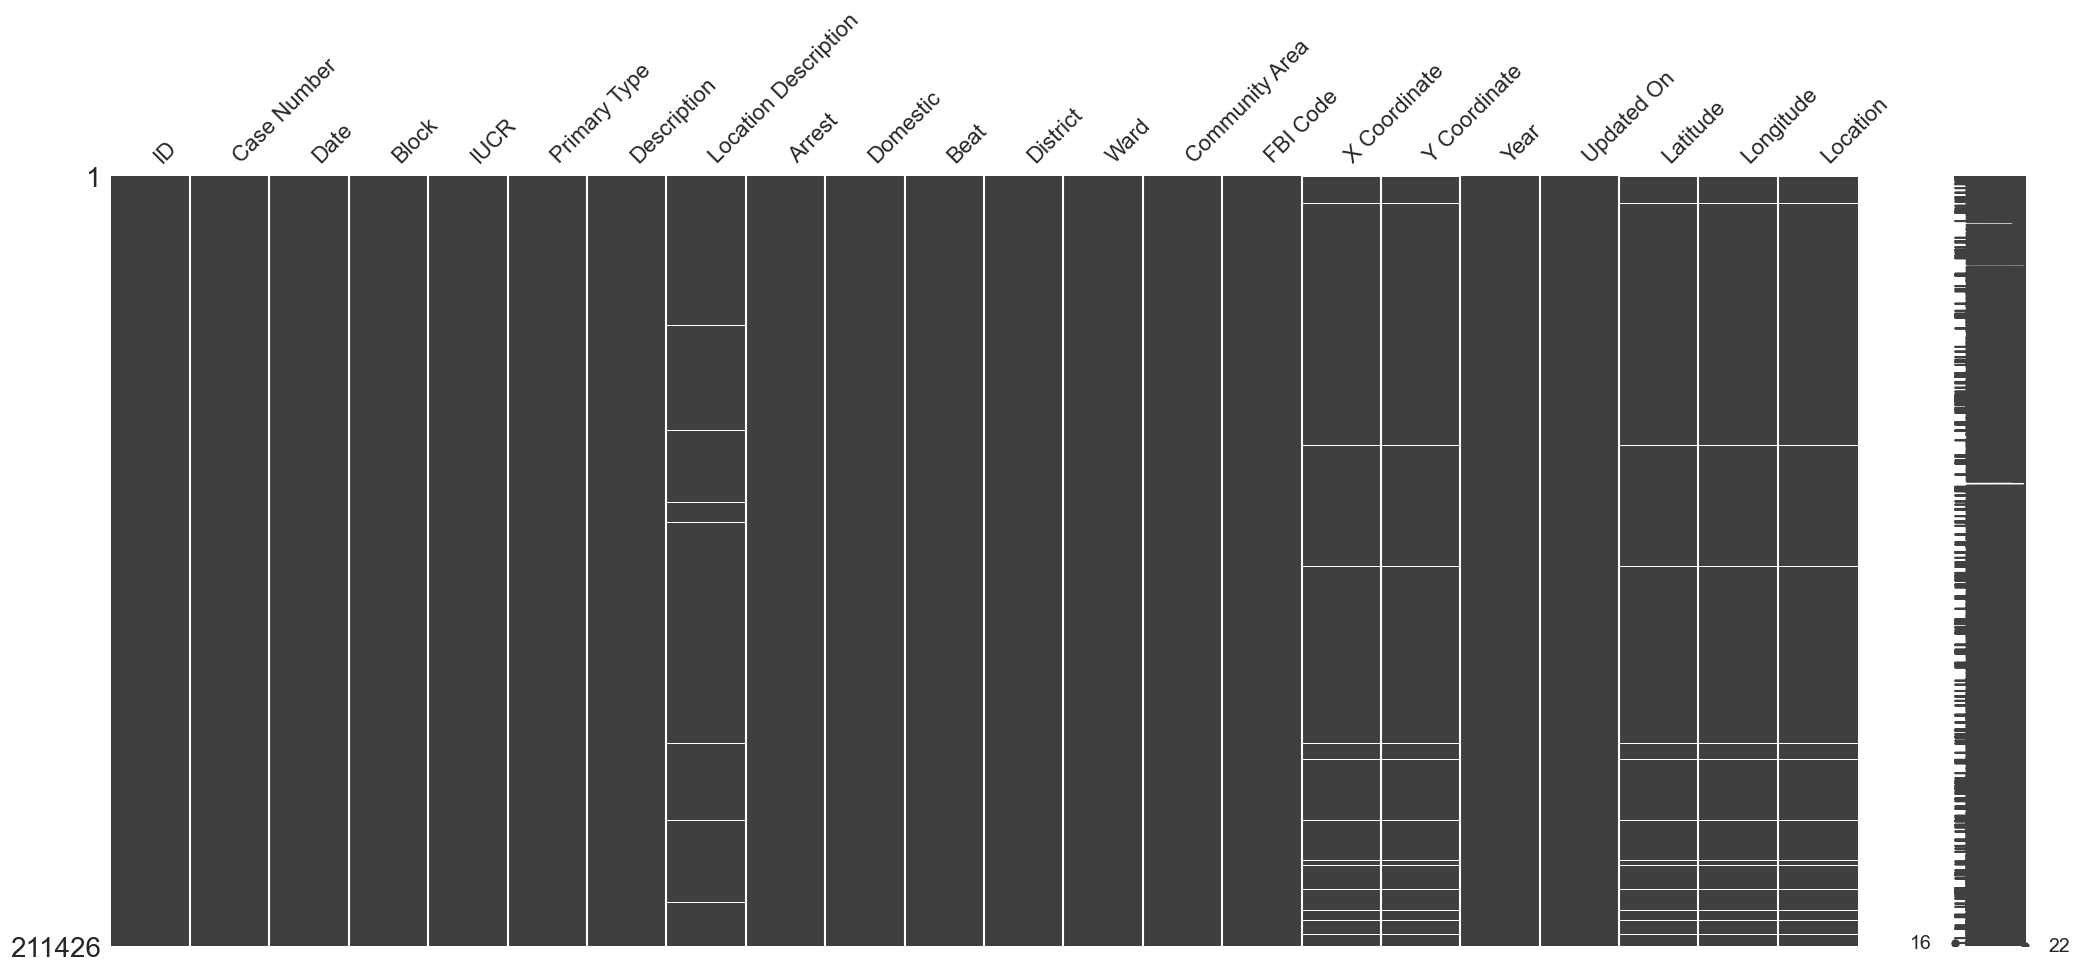

In [61]:
print(df20.shape)
msno.matrix(df20)

How many records having missing entry in total?

In [62]:
rows_having_missing = df20.isna().any(axis=1).sum()
print('incomplete records: {}'.format(rows_having_missing))
print('{:.2}% in total'.format(100 * rows_having_missing/df20.shape[0]))

incomplete records: 4503
2.1% in total


Therefore, we can simply discard all incomplete records.

In [63]:
df20 = df20.dropna()
print(df20.shape)

(206923, 22)


# Feature Study

show what features we've got

In [64]:
df20.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

We can split these features into 3 categories:
1. **crime related**: ID, Case Number, IUCR, Primary Type, Description, Arrest, Domestic, Beat, FBI Code
2. **location related**: Block, Location Description, District, Ward, Community Area, X Coordinate, Y Coordinate, Latitude, Longitude, Location
3. **time related**: Date, Year, Updated On

# Location Study

There are location related features: Block, Location Description, District, Ward, Community Area, X Coordinate, Y Coordinate, Latitude, Longitude, Location.

These features can also be divided into area features, such as Community Area, and spot features, such as X & Y Coordinate.

Let's go Community Area first.

In [65]:
df20['Community Area'].head()

0    22.0
1    47.0
2    56.0
3     6.0
5    66.0
Name: Community Area, dtype: float64

According to the [wikipedia](https://en.wikipedia.org/wiki/Community_areas_in_Chicago), we can know that there are 77 areas in total from 1 to 77.
However, the data type is float in the dataset. Therefore, we need to change the data type.

In [66]:
df20['Community Area'] = df20['Community Area'].astype('int')
df20['Community Area'].head()

0    22
1    47
2    56
3     6
5    66
Name: Community Area, dtype: int64

In [67]:
df20['Community Area'].describe()

count    206923.000000
mean         37.552505
std          21.501864
min           1.000000
25%          23.000000
50%          32.000000
75%          56.000000
max          77.000000
Name: Community Area, dtype: float64

Text(0.5, 1.0, 'Number of crimes on each area in 2020')

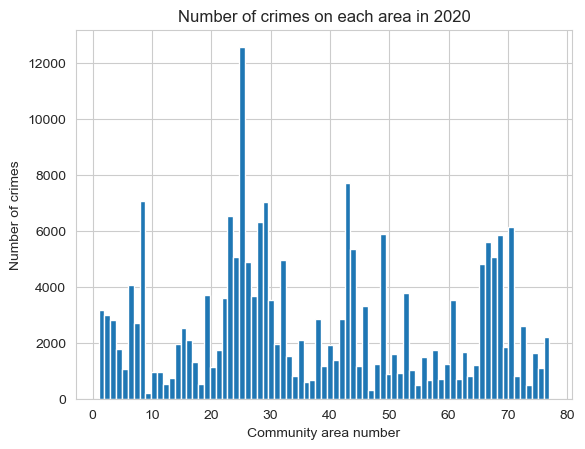

In [68]:
ax = df20['Community Area'].hist(bins=77)
ax.set_xlabel('Community area number')
ax.set_ylabel('Number of crimes')
ax.set_title('Number of crimes on each area in 2020')

And then, we check its frequency of crimes per community area. It's worth to notice that there is a community area having the number of crimes far beyond others, which is more than 12,000.

Text(0.5, 1.0, 'Distribution of crimes over areas in 2020')

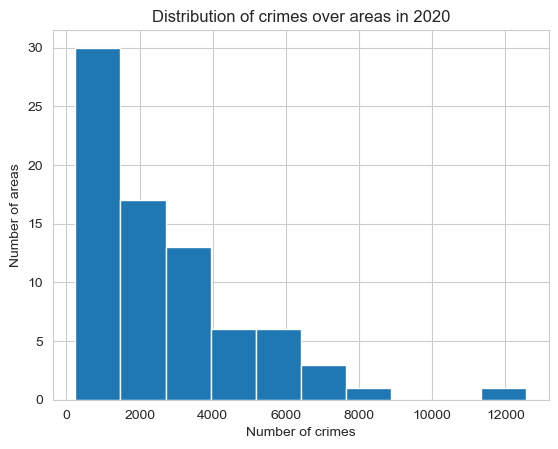

In [69]:
crimes_by_area = df20['Community Area'].value_counts()
ax = crimes_by_area.hist()
ax.set_xlabel('Number of crimes')
ax.set_ylabel('Number of areas')
ax.set_title('Distribution of crimes over areas in 2020')

In [70]:
crimes_by_area.describe()

count       77.000000
mean      2687.311688
std       2247.614755
min        243.000000
25%       1057.000000
50%       1854.000000
75%       3690.000000
max      12568.000000
Name: Community Area, dtype: float64

Text(0, 0.5, 'Number of crimes')

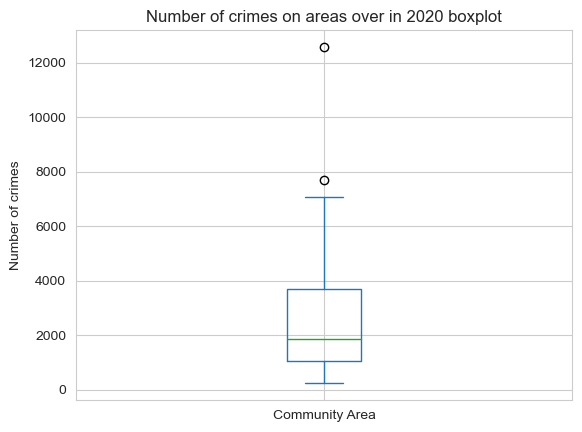

In [71]:
ax = crimes_by_area.plot.box()
ax.set_title('Number of crimes on areas over in 2020 boxplot')
ax.set_ylabel('Number of crimes')

In [72]:
crimes_by_area.median()

1854.0

In [73]:
crimes_by_area.sort_values(ascending=False)

25    12568
43     7708
8      7064
29     7029
23     6539
      ...  
12      533
74      500
55      496
47      337
9       243
Name: Community Area, Length: 77, dtype: int64

The average number of crimes among area is 2687.311688, and the median is 1854.0. From the boxplot, we can see that there are two outliers, which means these two areas are extremely affected by criminal activities. The most sinful community area is 25, and the second one is 43.

In [74]:
frame = gpd.read_file("{}Chicago_Areas.geojson".format(DATA_DIR))

In [75]:
frame['int_area_numbe'] = frame.area_numbe.map(lambda x: int(x))

In [76]:
frame['crime count by area'] = frame.int_area_numbe.map(lambda x: crimes_by_area[x] if x in crimes_by_area else 0)

<Figure size 1000x1400 with 0 Axes>

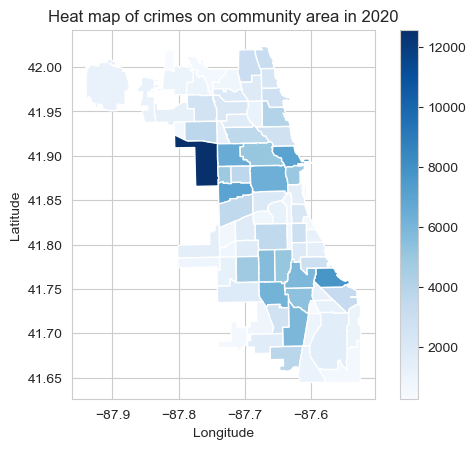

In [77]:
fig = plt.figure(figsize=(10, 14))
ax = frame.plot(column="crime count by area", legend=True, cmap='Blues')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heat map of crimes on community area in 2020')
plt.show()

In [78]:
frame[['area_numbe', 'crime count by area', 'community']].sort_values(by='crime count by area', ascending=False)

,area_numbe,crime count by area,community
25,25,12568,AUSTIN
38,43,7708,SOUTH SHORE
36,8,7064,NEAR NORTH SIDE
29,29,7029,NORTH LAWNDALE
23,23,6539,HUMBOLDT PARK
...,...,...,...
11,12,533,FOREST GLEN
72,74,500,MOUNT GREENWOOD
53,55,496,HEGEWISCH
42,47,337,BURNSIDE


Here we found that the most sinful community areas 25 and 43 are actually the Austin and South Shore.

<Figure size 1000x1400 with 0 Axes>

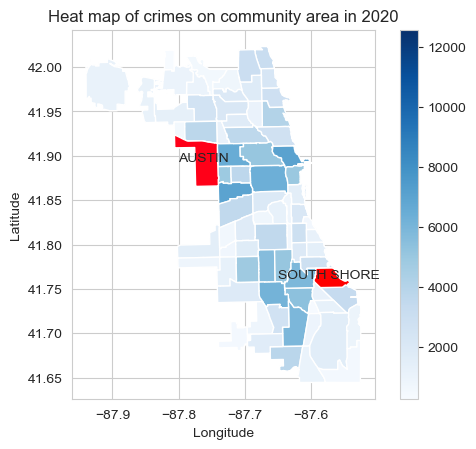

In [79]:
fig = plt.figure(figsize=(10, 14))
ax = frame.plot(column="crime count by area", legend=True, cmap='Blues')
ax = frame.sort_values(by='crime count by area', ascending=False)[:2].plot(column='crime count by area', cmap='hsv', ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
frame.sort_values(by='crime count by area', ascending=False)[:2].apply(lambda x: ax.annotate(text=x['community'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.title('Heat map of crimes on community area in 2020')
plt.show()

# Time Study

In [80]:
format = '%m/%d/%Y %H:%M:%S %p'
df20['DatetimeIndex'] = pd.to_datetime(df20['Date'], format=format)
df20.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,DatetimeIndex
0,12016034,JD193556,01/01/2020 12:00:00 AM,018XX N WINNEBAGO AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,22,11,1160263.0,1912391.0,2020,03/26/2020 03:45:12 PM,41.915306,-87.686639,"(41.915306069, -87.686639247)",2020-01-01 12:00:00
1,12220321,JD430436,01/01/2020 12:00:00 AM,091XX S DREXEL AVE,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,47,17,1184157.0,1844395.0,2020,12/19/2020 03:45:59 PM,41.728192,-87.600985,"(41.728192429, -87.600985433)",2020-01-01 12:00:00
2,12013828,JD191019,01/01/2020 12:00:00 AM,044XX S LAVERGNE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,...,56,02,1143770.0,1874726.0,2020,03/28/2020 03:47:02 PM,41.812274,-87.748177,"(41.81227369, -87.748176594)",2020-01-01 12:00:00
3,12019692,JD197444,01/01/2020 12:00:00 AM,032XX N LINCOLN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,6,11,1164983.0,1921507.0,2020,04/01/2020 03:50:17 PM,41.940222,-87.669039,"(41.940221932, -87.669039008)",2020-01-01 12:00:00
5,12036792,JD216459,01/01/2020 12:00:00 AM,072XX S WHIPPLE ST,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,...,66,11,1157290.0,1856526.0,2020,04/29/2020 03:53:17 PM,41.762067,-87.699077,"(41.762066981, -87.699077348)",2020-01-01 12:00:00


In [81]:
crimes_hour = df20[['DatetimeIndex', 'ID']].resample('H', on='DatetimeIndex', label='left').count()
crimes_hour.rename(columns={'ID': 'crimes'}, inplace=True)
crimes_hour

,crimes
DatetimeIndex,
2020-01-01 01:00:00,85
2020-01-01 02:00:00,82
2020-01-01 03:00:00,66
2020-01-01 04:00:00,56
2020-01-01 05:00:00,57
...,...
2020-12-31 08:00:00,0
2020-12-31 09:00:00,0
2020-12-31 10:00:00,0


Text(0, 0.5, 'Number of crimes')

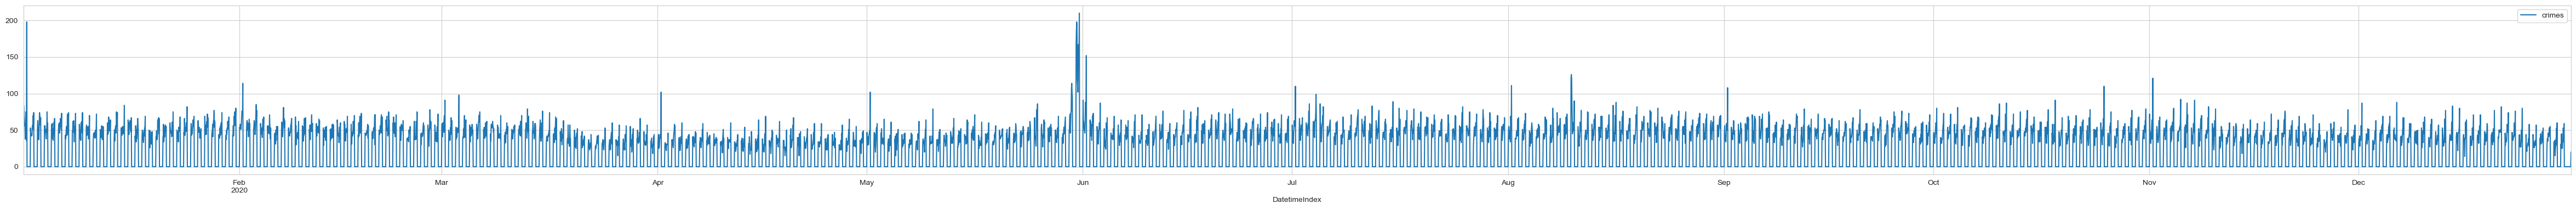

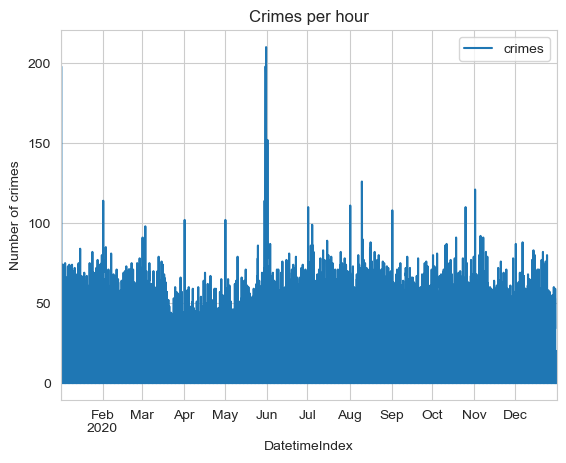

In [82]:
crimes_hour.plot(figsize=(60,4))
ax = crimes_hour.plot(title='Crimes per hour')
ax.set_ylabel('Number of crimes')

The x-axis is so narrow that makes it like a bar chart.

In [83]:
crimes_hour.describe()

,crimes
count,8772.000000
mean,23.589033
std,25.710706
min,0.000000
25%,0.000000
50%,0.000000
75%,46.000000
max,210.000000


Text(0, 0.5, 'Number of crimes')

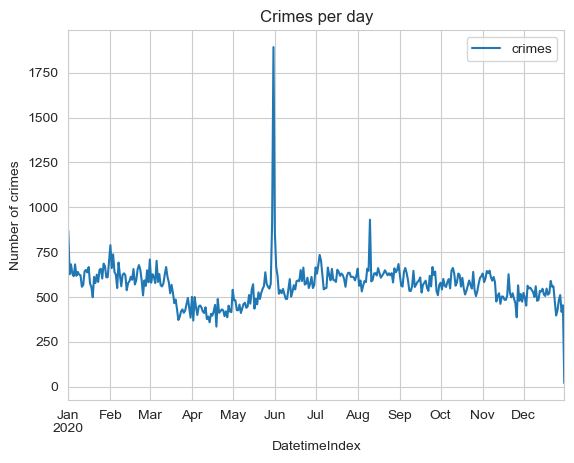

In [84]:
crimes_day = crimes_hour.resample('D', label='left').sum()
ax = crimes_day.plot(title='Crimes per day')
ax.set_ylabel('Number of crimes')

In [85]:
crimes_day.describe()

,crimes
count,366.000000
mean,565.363388
std,114.820750
min,20.000000
25%,509.250000
50%,569.500000
75%,622.750000
max,1893.000000


Text(0, 0.5, 'Number of crimes')

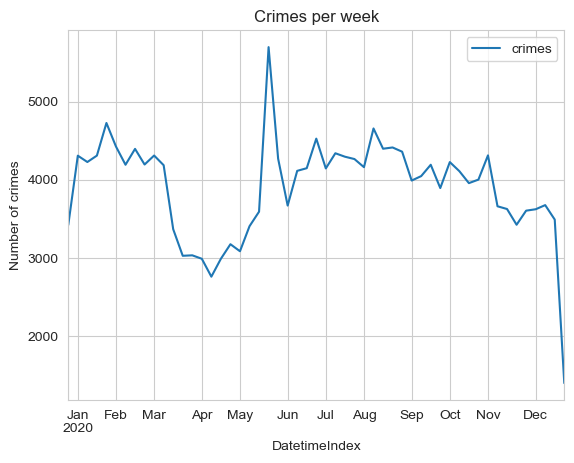

In [86]:
crimes_week = crimes_hour.resample('W', label='left').sum()
ax = crimes_week.plot(title='Crimes per week')
ax.set_ylabel('Number of crimes')

In [87]:
crimes_week.describe()

,crimes
count,53.000000
mean,3904.207547
std,647.799333
min,1402.000000
25%,3594.000000
50%,4116.000000
75%,4310.000000
max,5698.000000


Text(0, 0.5, 'Number of crimes')

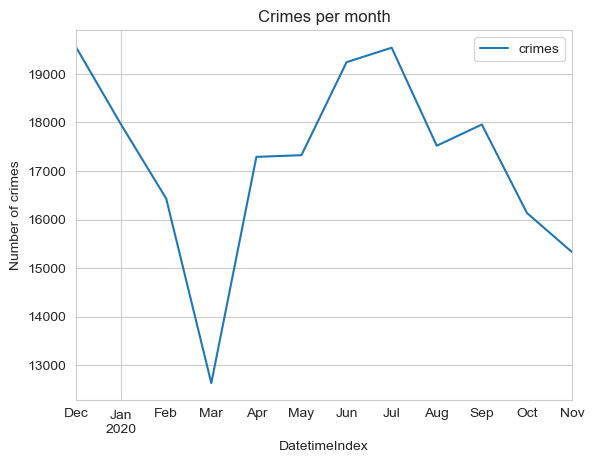

In [88]:
crimes_month = crimes_hour.resample('M', label='left').sum()
ax = crimes_month.plot(title='Crimes per month')
ax.set_ylabel('Number of crimes')

In [89]:
crimes_month.describe()

,crimes
count,12.000000
mean,17243.583333
std,1965.561657
min,12633.000000
25%,16359.000000
50%,17424.500000
75%,18279.000000
max,19552.000000


# Further Investigation

## Can we also just discard missing data in other years?

In [90]:
size_df = pd.read_csv('{}size.csv'.format(DATA_GEN_DIR)).sort_values(by=['year'])
size_df

,year,size,dimension,size after,size dropped
0,2010,369664,22,368984,680
1,2011,351164,22,350121,1043
2,2012,335520,22,334370,1150
3,2013,306897,22,305774,1123
4,2014,275138,22,273039,2099
5,2015,264115,22,257237,6878
6,2016,269074,22,265794,3280
7,2017,268484,22,263630,4854
9,2018,268061,22,262221,5840
8,2019,260627,22,257635,2992


In [91]:
size_df['dropped percentage'] = size_df.apply(lambda x: '{:.2} %'.format(100*x['size dropped']/x['size']), axis=1)

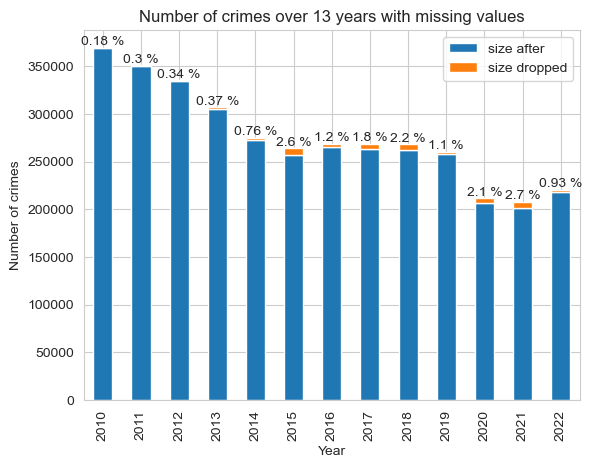

In [92]:
fig, ax = plt.subplots()
ax = size_df[['year', 'size after', 'size dropped',]]\
    .set_index('year')\
    .plot.bar(stacked=True, ax=ax)
ax.set_ylabel('Number of crimes')
ax.set_xlabel('Year')
ax.set_title('Number of crimes over 13 years with missing values')
_ = ax.bar_label(ax.containers[-1], size_df['dropped percentage'])

Thus, we can simply discard all the missing data.

Besides that, we can also see that in the past 13 years the number of crimes was roughly decreasing. From 2010 to 2015, it dropped rapidly. Then, it had been stabilized for 4 years with little fluctuations. When it came to 2020, it decreased suddenly and then had a sign to increase. The significant decline may be caused by the COVID-19.

## Changes of the worst top5 and bottom5 areas over 13 years

In [93]:
cay_df = pd.read_csv('{}crime_area_year.csv'.format(DATA_GEN_DIR))
cay_df

,Community Area,Counts,Year
0,25,24230,2010
1,43,12289,2010
2,23,11802,2010
3,8,11546,2010
4,24,11321,2010
...,...,...,...
996,55,567,2022
997,12,556,2022
998,74,493,2022
999,47,300,2022


In [94]:
worst_area_td = cay_df.sort_values(by=['Year', 'Counts'], ascending=[True, False])\
    .groupby(by='Year')
worst_area_top5 = worst_area_td.head(5)
worst_area_bot5 = worst_area_td.tail(5)
worst_area_top5

,Community Area,Counts,Year
0,25,24230,2010
1,43,12289,2010
2,23,11802,2010
3,8,11546,2010
4,24,11321,2010
...,...,...,...
924,25,11435,2022
925,8,9628,2022
926,28,8624,2022
927,43,7723,2022


In [95]:
wat5y = worst_area_top5['Community Area'].value_counts()
wat5y

25    13
8     13
29    10
43     9
23     7
28     6
32     5
24     1
67     1
Name: Community Area, dtype: int64

From this table, we can clearly see that the frequencies of area being top5 the worst area over the 13 years.

In [96]:
name_numb = pd.concat([
    frame['int_area_numbe'],
    frame['community']
], axis=1)
name_numb = name_numb.merge(wat5y, how='right', left_on='int_area_numbe', right_index=True)
name_numb_index = name_numb[name_numb['Community Area']>1].index
name_numb

,int_area_numbe,community,Community Area
25,25,AUSTIN,13
36,8,NEAR NORTH SIDE,13
29,29,NORTH LAWNDALE,10
38,43,SOUTH SHORE,9
23,23,HUMBOLDT PARK,7
28,28,NEAR WEST SIDE,6
37,32,LOOP,5
24,24,WEST TOWN,1
64,67,WEST ENGLEWOOD,1


Community Areas 25, 8, 29, 43, 23, 28, 32, which are AUSTIN,NEAR NORTH SIDE,NORTH LAWNDALE,SOUTH SHORE,HUMBOLDT PARK, has been the worst area top 5 more than once in the past 13 years.


**Consistent ranking** refers to a situation where something consistently ranks in the same position or within a specific range over a period of time. I

<Figure size 1000x1400 with 0 Axes>

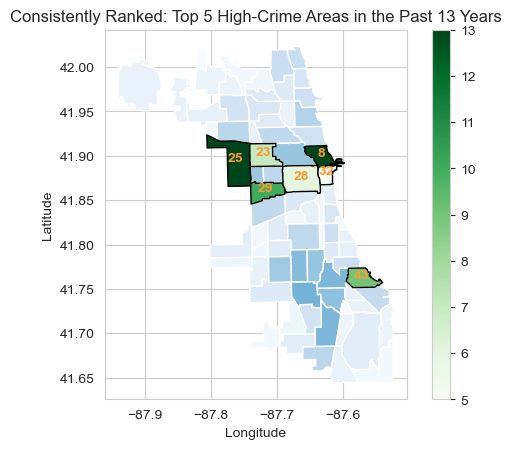

In [97]:
wat5y_area = [25, 8, 29, 43, 23, 28, 32]
fig = plt.figure(figsize=(10, 14))
ax = frame.plot(column="crime count by area", legend=False, cmap='Blues')
frame_t5 = frame.merge(name_numb[name_numb['Community Area']>1], left_index=True, right_index=True).sort_values(by='Community Area', ascending=False)
ax = frame_t5.plot(column='Community Area', legend=True, cmap='Greens', linewidth=1, edgecolor='black', ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Consistently Ranked: Top 5 High-Crime Areas in the Past 13 Years')
_ = frame.iloc[name_numb_index].apply(lambda x: ax.annotate(text=x['area_numbe'], xy=x.geometry.centroid.coords[0], ha='center', color='#FF9933', weight='bold'), axis=1)

The darker, the more times being top 5 in the past 13 years.

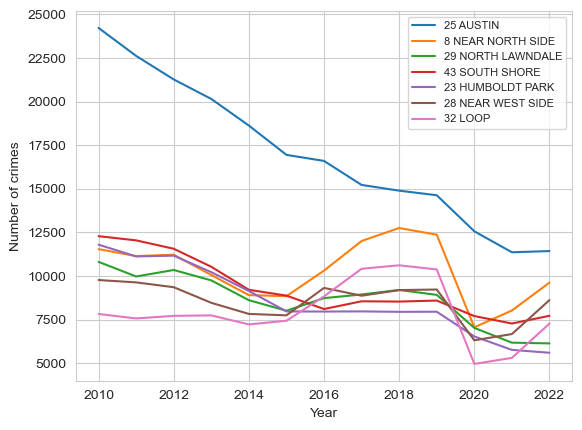

In [98]:
fig, ax = plt.subplots()
cay_gp = cay_df.groupby(by='Community Area')
for area in wat5y_area:
    df = cay_gp.get_group(area)
    df = df.sort_values(by='Year', ascending=True)
    area_name = frame[frame['int_area_numbe'] == area]['community'].to_string(index=False)
    df.plot.line(x='Year', y='Counts', ax=ax, label='{} {}'.format(area, area_name))

# ax.set_title('Changes of top5 worst areas over 13 years')
ax.set_ylabel('Number of crimes')
ax.legend(prop={'size':8})

In [99]:

wad5y = worst_area_bot5['Community Area'].value_counts()
name_numb = pd.concat([
    frame['int_area_numbe'],
    frame['community']
], axis=1)
name_numb = name_numb.merge(wad5y, how='right', left_on='int_area_numbe', right_index=True)
name_numb

,int_area_numbe,community,Community Area
11,12,FOREST GLEN,13
42,47,BURNSIDE,13
76,9,EDISON PARK,13
72,74,MOUNT GREENWOOD,10
53,55,HEGEWISCH,8
17,18,MONTCLARE,6
1,36,OAKLAND,2


Comparing to top5, bottom5 are more stable.

<Figure size 1000x1400 with 0 Axes>

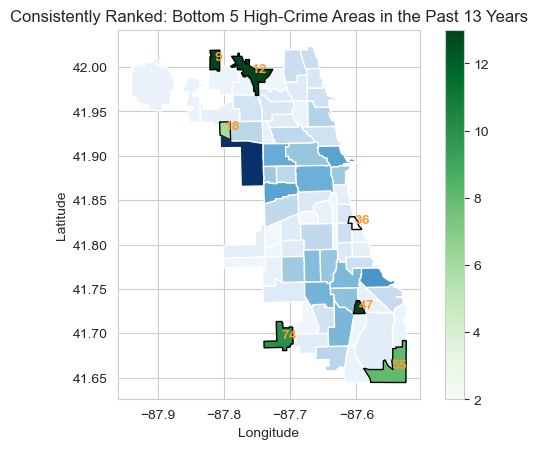

In [100]:
fig = plt.figure(figsize=(10, 14))
ax = frame.plot(column="crime count by area", legend=False, cmap='Blues')
frame_d5 = frame.merge(name_numb, left_index=True, right_index=True).sort_values(by='Community Area', ascending=False)
ax = frame_d5.plot(column='Community Area', legend=True, cmap='Greens', linewidth=1, edgecolor='black', ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Consistently Ranked: Bottom 5 High-Crime Areas in the Past 13 Years')
_ = frame.iloc[name_numb.index].apply(lambda x: ax.annotate(text=x['area_numbe'], xy=x.geometry.centroid.coords[0], ha='left', color='#FF9933', weight='bold'), axis=1)

The darker, the more times being bottom 5 in the past 13 years. In other words, it is safer.

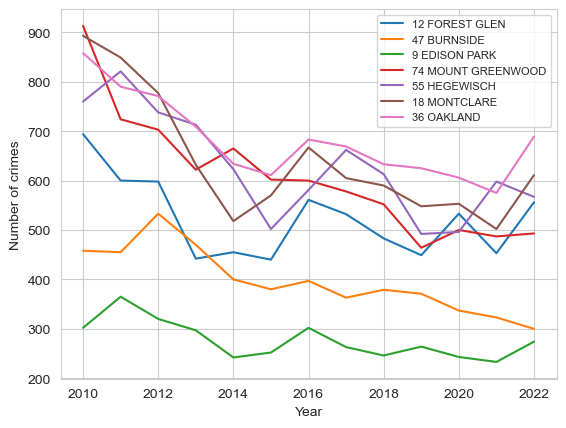

In [101]:
fig, ax = plt.subplots()
cay_gp = cay_df.groupby(by='Community Area')
for area in name_numb['int_area_numbe']:
    df = cay_gp.get_group(area)
    df = df.sort_values(by='Year', ascending=True)
    area_name = frame[frame['int_area_numbe'] == area]['community'].to_string(index=False)
    df.plot.line(x='Year', y='Counts', ax=ax, label='{} {}'.format(area, area_name))

# ax.set_title('Changes of bottom5 worst areas over 13 years')
ax.set_ylabel('Number of crimes')
ax.legend(prop={'size':8})

## What are the main criminal types for each city in 2020?

In [102]:
df20['Primary Type'].unique()

array(['DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN',
       'CRIMINAL SEXUAL ASSAULT', 'THEFT', 'OTHER OFFENSE', 'ASSAULT',
       'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION',
       'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ROBBERY',
       'MOTOR VEHICLE THEFT', 'NARCOTICS', 'PUBLIC PEACE VIOLATION',
       'CRIMINAL TRESPASS', 'LIQUOR LAW VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'KIDNAPPING',
       'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE', 'STALKING',
       'ARSON', 'INTIMIDATION', 'OTHER NARCOTIC VIOLATION', 'GAMBLING',
       'PROSTITUTION', 'OBSCENITY', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL', 'RITUALISM'], dtype=object)

In [103]:
type_area_20 = df20.groupby(by=['Primary Type', 'Community Area'])\
    .count()\
    .iloc[:, 0]\
    .unstack()\
    .fillna(0)\
    .transpose()
type_area_20

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Community Area,,,,,,,,,,,,,,,,,,,,,
1,1.0,272.0,623.0,117.0,0.0,5.0,440.0,29.0,59.0,268.0,...,171.0,1.0,1.0,10.0,0.0,115.0,22.0,5.0,803.0,33.0
2,4.0,228.0,564.0,167.0,0.0,4.0,387.0,8.0,63.0,312.0,...,161.0,0.0,0.0,11.0,0.0,99.0,16.0,2.0,745.0,31.0
3,4.0,245.0,522.0,112.0,1.0,2.0,270.0,25.0,64.0,335.0,...,126.0,0.0,0.0,21.0,0.0,100.0,16.0,0.0,773.0,27.0
4,1.0,105.0,288.0,100.0,1.0,0.0,207.0,15.0,45.0,221.0,...,67.0,0.0,0.0,2.0,0.0,33.0,6.0,2.0,591.0,6.0
5,5.0,63.0,101.0,84.0,0.0,1.0,93.0,4.0,32.0,192.0,...,58.0,0.0,0.0,8.0,0.0,27.0,5.0,1.0,345.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,7.0,239.0,515.0,114.0,1.0,1.0,349.0,17.0,53.0,248.0,...,189.0,0.0,0.0,6.0,0.0,93.0,14.0,2.0,419.0,116.0
74,1.0,33.0,70.0,13.0,2.0,1.0,50.0,1.0,15.0,146.0,...,48.0,1.0,0.0,2.0,0.0,4.0,5.0,0.0,68.0,3.0
75,1.0,160.0,291.0,87.0,0.0,1.0,208.0,3.0,23.0,202.0,...,109.0,0.0,0.0,3.0,0.0,49.0,5.0,3.0,297.0,45.0


<AxesSubplot:xlabel='Primary Type', ylabel='Community Area'>

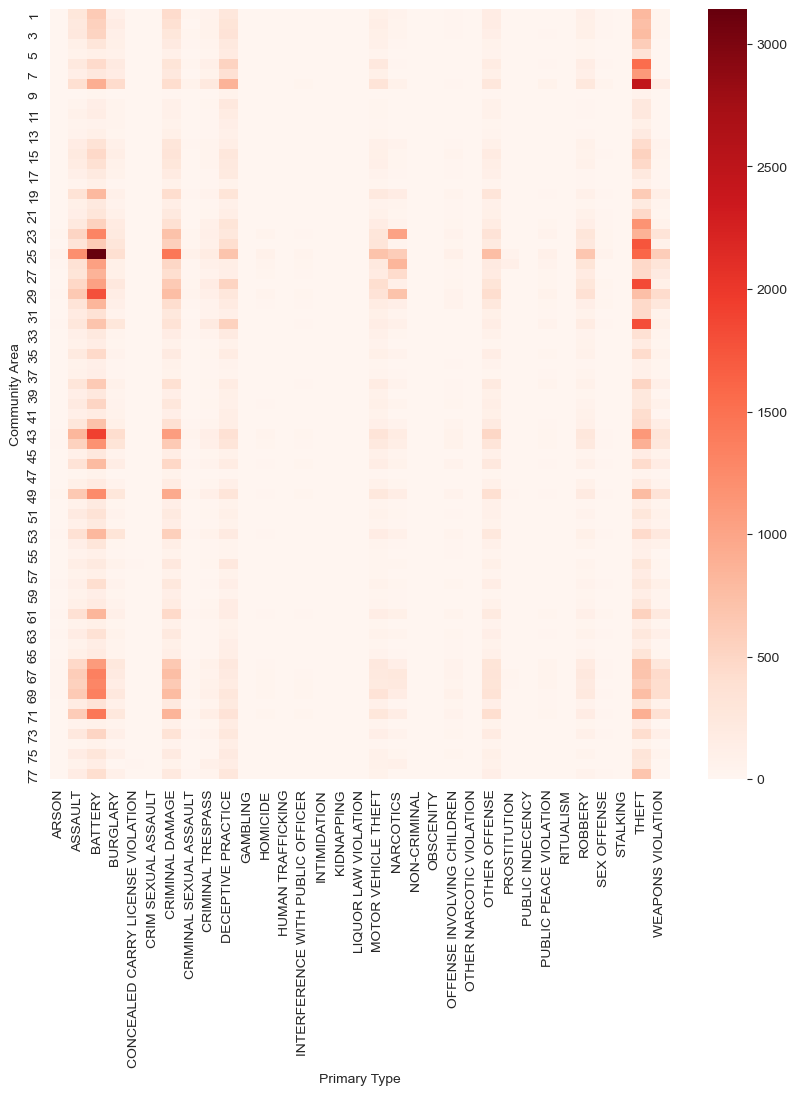

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(type_area_20, cmap='Reds', ax=ax)

### criminal types of top 5 cities

In [105]:
wat5y_type_area_20 = type_area_20.merge(wat5y, left_index=True, right_index=True).sort_values(by='Community Area', ascending=False)
wat5y_type_area_20

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Community Area
8,3.0,398.0,914.0,440.0,2.0,6.0,420.0,64.0,226.0,863.0,...,1.0,0.0,62.0,0.0,251.0,37.0,8.0,2454.0,170.0,13
25,56.0,1212.0,3141.0,397.0,2.0,5.0,1445.0,75.0,182.0,689.0,...,50.0,0.0,90.0,0.0,674.0,55.0,7.0,1600.0,590.0,13
29,22.0,645.0,1787.0,157.0,7.0,1.0,758.0,39.0,118.0,264.0,...,4.0,0.0,66.0,0.0,372.0,21.0,4.0,743.0,437.0,10
43,15.0,832.0,1915.0,427.0,2.0,3.0,1072.0,42.0,123.0,374.0,...,0.0,0.0,36.0,0.0,263.0,18.0,8.0,1128.0,297.0,9
23,25.0,514.0,1321.0,220.0,1.0,2.0,712.0,26.0,113.0,250.0,...,3.0,0.0,52.0,0.0,284.0,26.0,4.0,879.0,320.0,7
28,8.0,481.0,1033.0,238.0,3.0,1.0,635.0,27.0,168.0,527.0,...,1.0,0.0,34.0,0.0,273.0,30.0,10.0,1835.0,109.0,6
32,15.0,268.0,690.0,270.0,1.0,1.0,351.0,22.0,200.0,548.0,...,0.0,1.0,59.0,0.0,181.0,19.0,1.0,1808.0,99.0,5
24,8.0,323.0,623.0,292.0,0.0,0.0,572.0,25.0,89.0,414.0,...,1.0,1.0,11.0,0.0,242.0,29.0,1.0,1751.0,74.0,1
67,18.0,595.0,1361.0,198.0,7.0,4.0,749.0,31.0,61.0,201.0,...,31.0,1.0,43.0,0.0,235.0,17.0,7.0,693.0,453.0,1


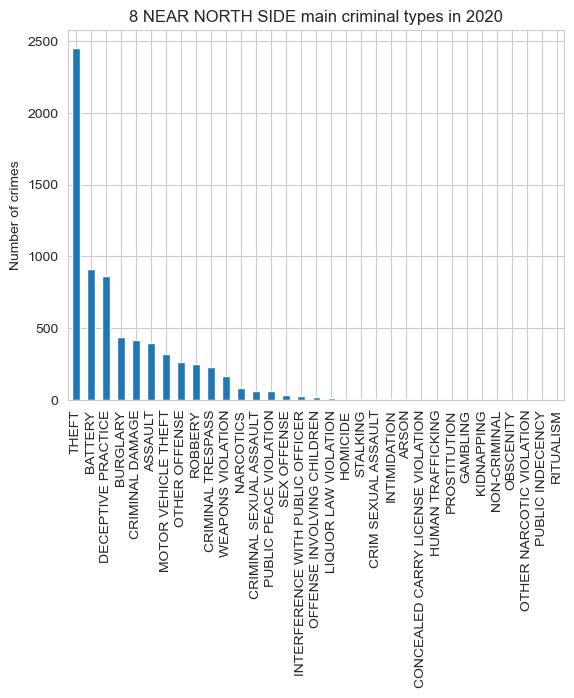

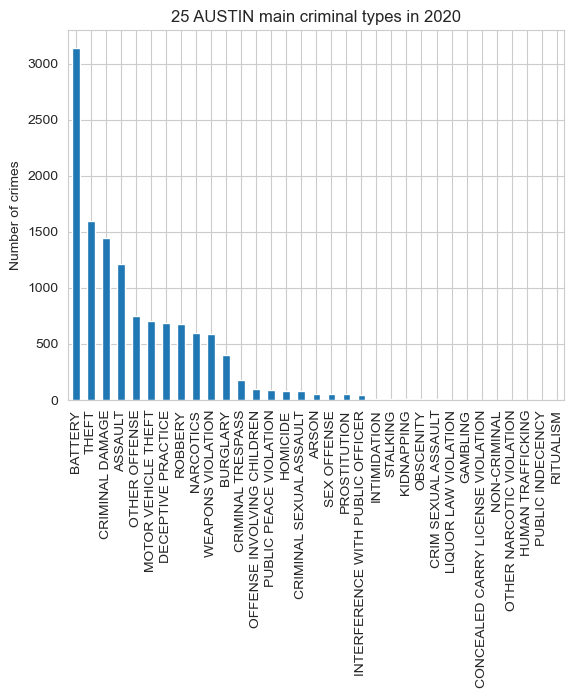

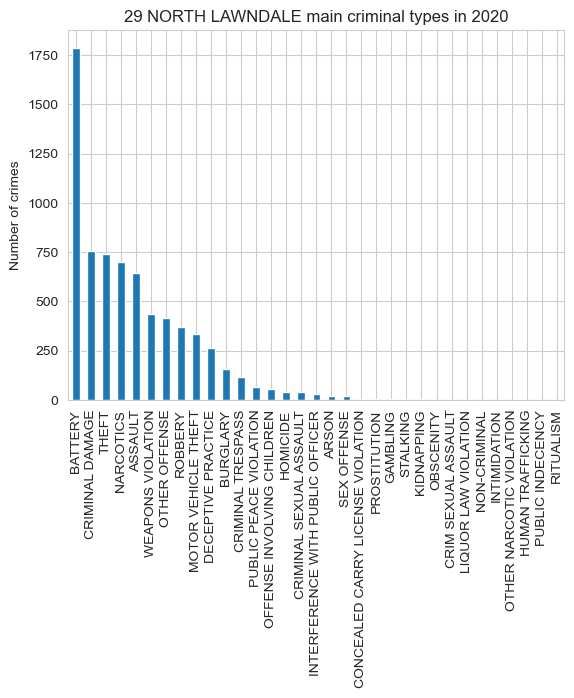

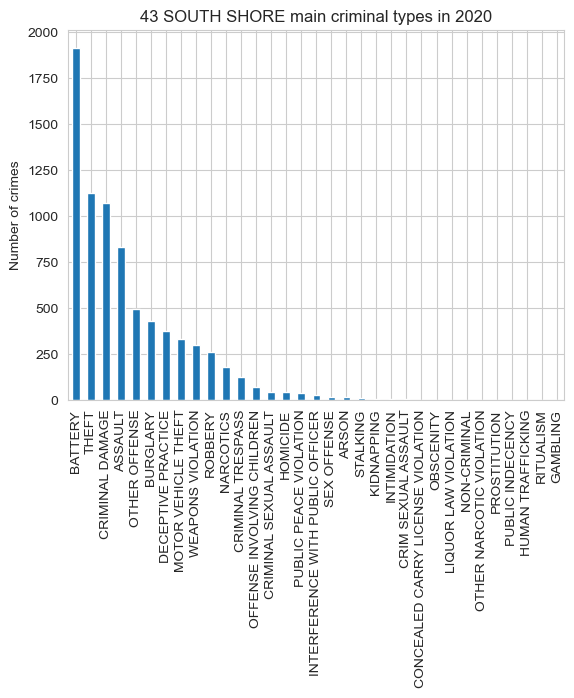

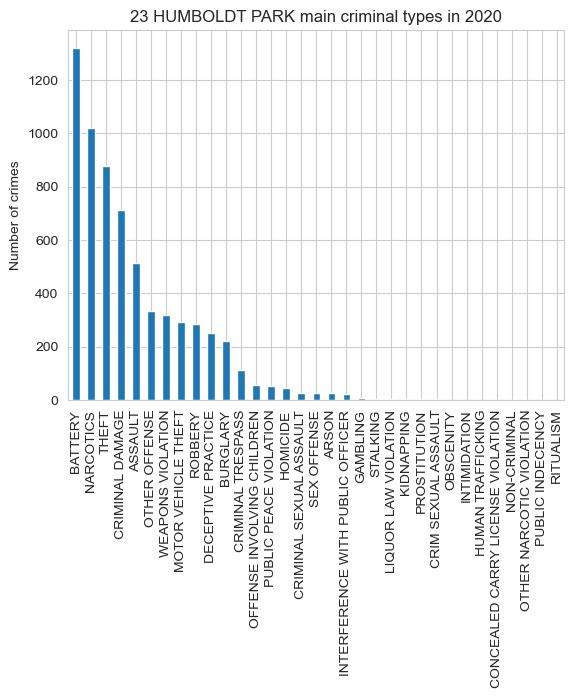

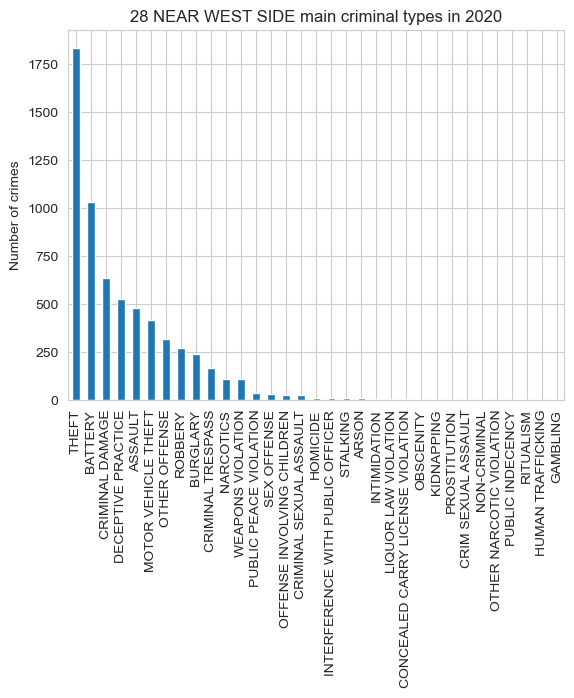

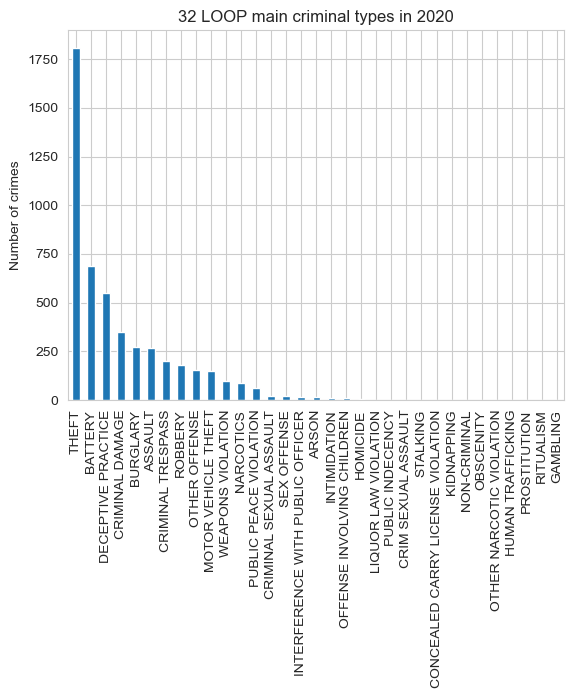

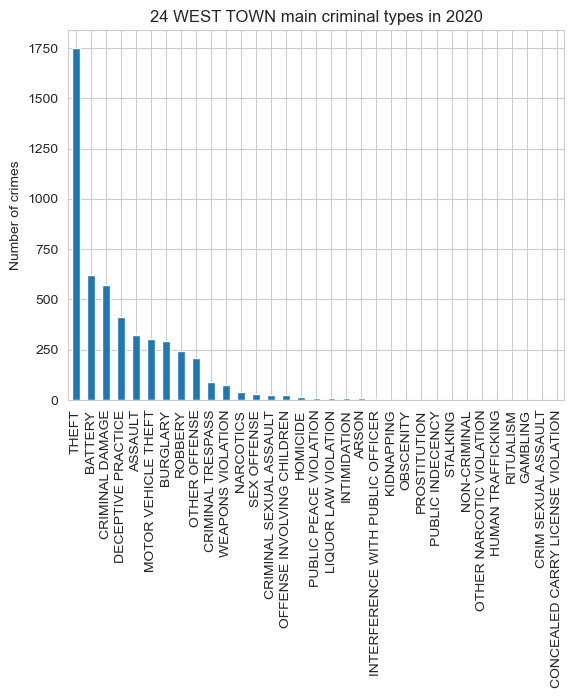

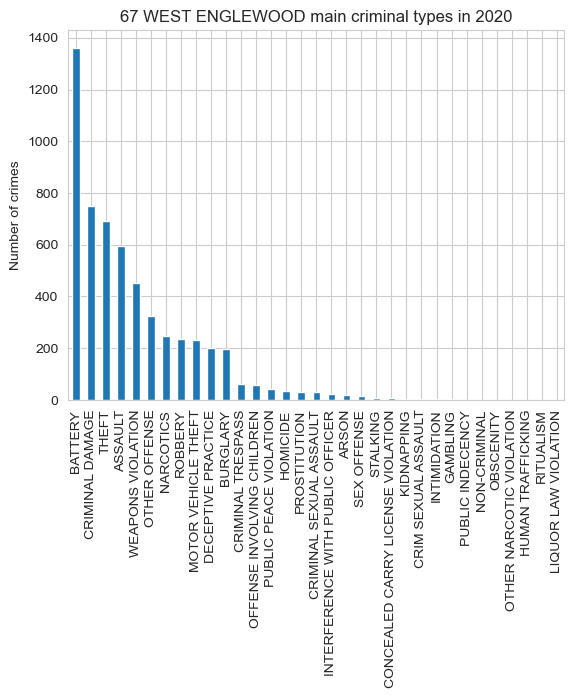

In [106]:
def draw_each_city(r):
    plt.figure()
    area_num = r.name
    area_name = frame[frame['int_area_numbe'] == area_num]['community'].to_string(index=False)
    ax = r.sort_values(ascending=False).plot.bar(title=str(area_num)+' '+area_name+' main criminal types in 2020')
    ax.set_ylabel('Number of crimes')
_ = wat5y_type_area_20.drop(['Community Area'], axis=1).apply(draw_each_city, axis=1)

### criminal types of bottom 5 cities

In [107]:
wad5y_type_area_20 = type_area_20.merge(wad5y, left_index=True, right_index=True).sort_values(by='Community Area', ascending=False)
wad5y_type_area_20

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Community Area
9,0.0,11.0,28.0,11.0,0.0,0.0,17.0,1.0,9.0,73.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,57.0,1.0,13
12,1.0,47.0,53.0,44.0,0.0,0.0,67.0,1.0,20.0,131.0,...,0.0,0.0,4.0,0.0,7.0,3.0,1.0,104.0,3.0,13
47,0.0,30.0,71.0,12.0,0.0,0.0,72.0,0.0,4.0,20.0,...,0.0,0.0,3.0,0.0,9.0,0.0,0.0,38.0,19.0,13
74,1.0,33.0,70.0,13.0,2.0,1.0,50.0,1.0,15.0,146.0,...,1.0,0.0,2.0,0.0,4.0,5.0,0.0,68.0,3.0,10
55,2.0,54.0,95.0,16.0,0.0,0.0,69.0,2.0,17.0,40.0,...,0.0,0.0,0.0,0.0,8.0,1.0,0.0,89.0,8.0,8
18,1.0,41.0,106.0,20.0,0.0,0.0,85.0,5.0,13.0,65.0,...,0.0,0.0,2.0,0.0,13.0,1.0,1.0,95.0,13.0,6
36,0.0,71.0,118.0,16.0,0.0,0.0,81.0,3.0,13.0,52.0,...,0.0,0.0,1.0,0.0,20.0,2.0,1.0,97.0,26.0,2


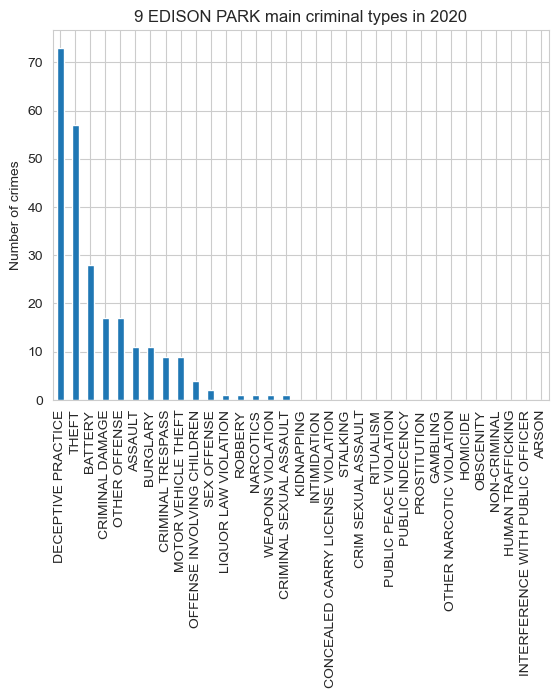

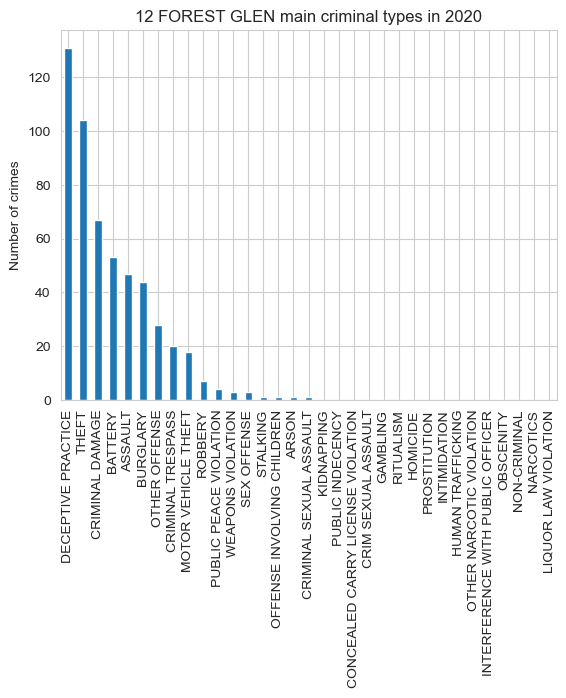

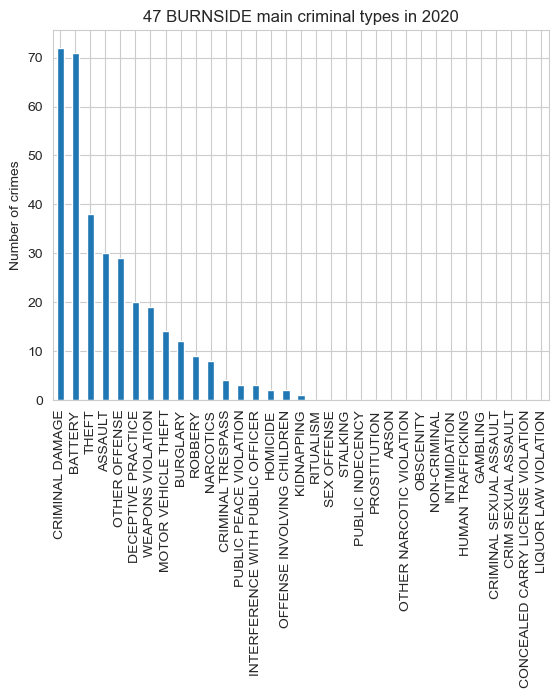

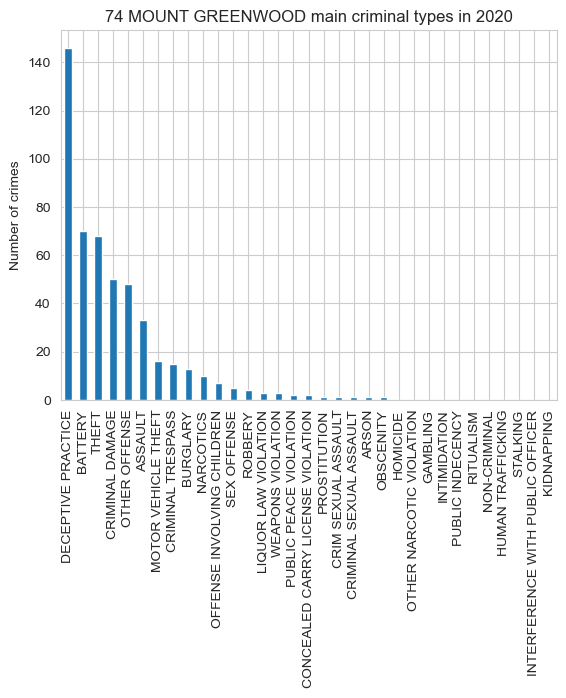

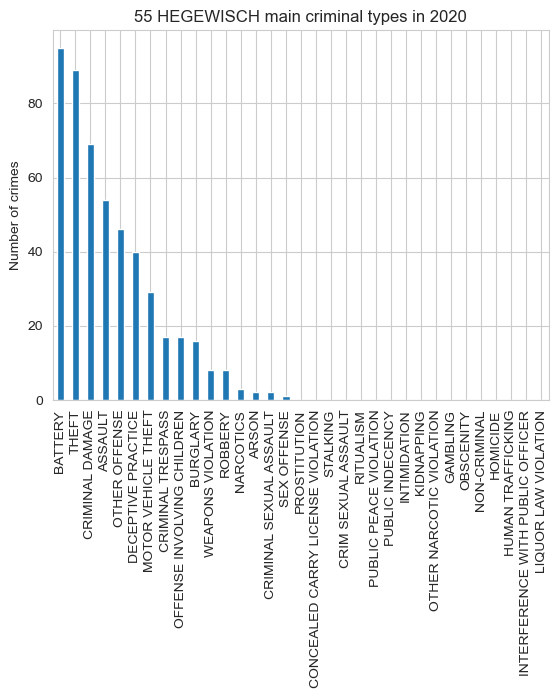

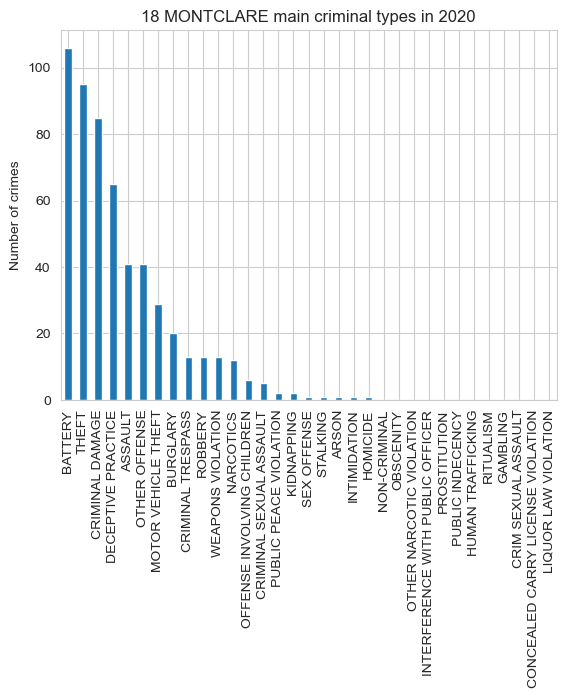

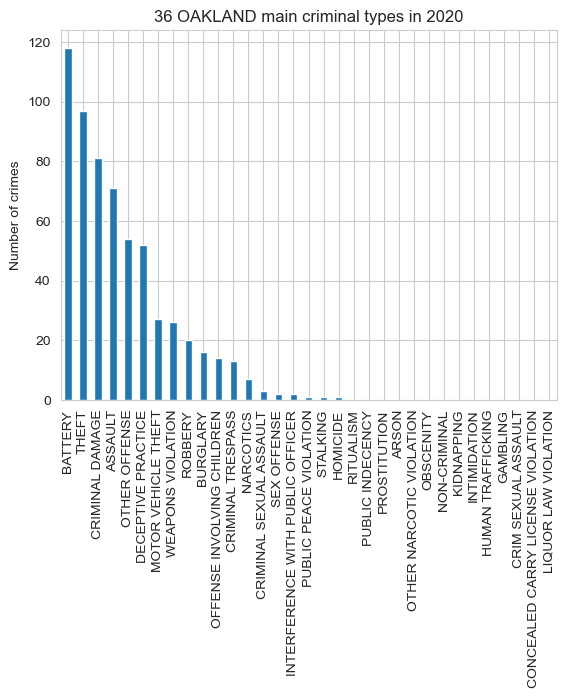

In [108]:
_ = wad5y_type_area_20.drop(['Community Area'], axis=1).apply(draw_each_city, axis=1)

### Conclusion
No matter in the top 5 or bottom 5 worst cities, the main criminal types are battery and theft. The difference is just the magnitude.

## number of crimes on areas over 13 years


In [109]:
crimes_areas_13years_df = cay_df.groupby(by='Community Area').sum().drop(['Year'], axis=1).reset_index()

In [110]:
import numpy as np
np.arange(0, 10, 1)
range(0, 10, 1)

range(0, 10)

Text(0, 0.5, 'Number of crimes')

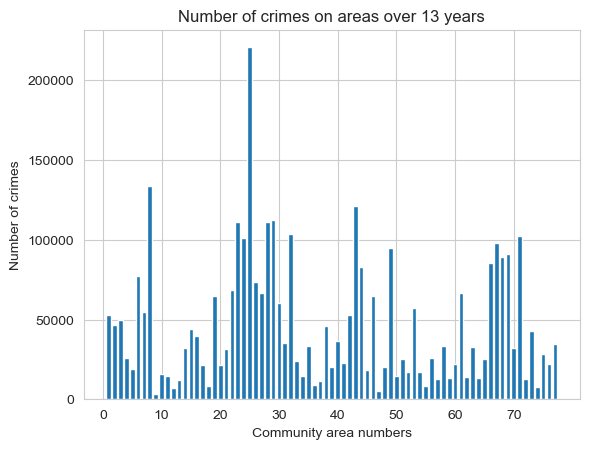

In [111]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xticks(np.arange(0, 80, 10))
ax.bar(x=crimes_areas_13years_df['Community Area'], height=crimes_areas_13years_df['Counts'])
ax.set_title('Number of crimes on areas over 13 years')
ax.set_xlabel('Community area numbers')
ax.set_ylabel('Number of crimes')


Text(0, 0.5, 'Number of community areas')

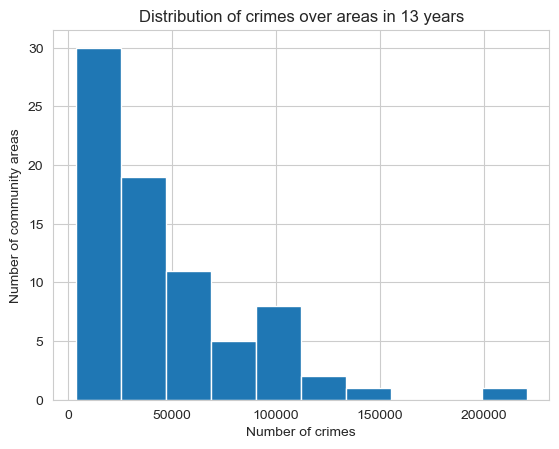

In [112]:
fig = plt.figure()
ax = fig.add_subplot()
crimes_areas_13years_df.set_index('Community Area').hist(ax=ax)
ax.set_title('Distribution of crimes over areas in 13 years')
ax.set_xlabel('Number of crimes')
ax.set_ylabel('Number of community areas')

Text(0, 0.5, 'Number of crimes')

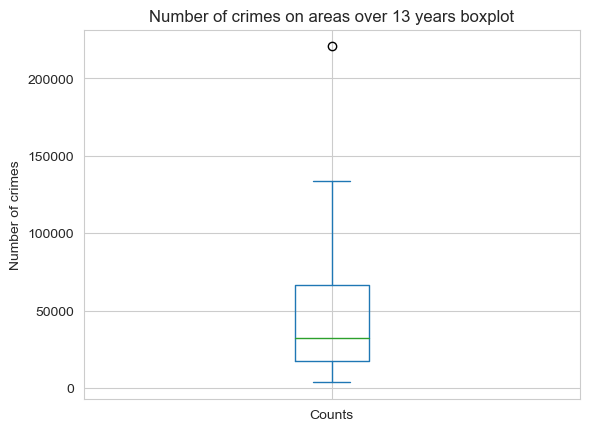

In [113]:
ax = crimes_areas_13years_df.set_index('Community Area').plot.box()
ax.set_title('Number of crimes on areas over 13 years boxplot')
ax.set_ylabel('Number of crimes')

Where the outlier is

In [114]:
crimes_areas_13years_df.iloc[crimes_areas_13years_df['Counts'].idxmax()]

Community Area        25
Counts            220605
Name: 24, dtype: int64